### Import libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta


### Customize

In [2]:
# Customize parameters
my_input_data = "0712 market_data.csv"
my_area_chart = "0712 portfolio_weights_dynamic_area_chart.png"
my_returns = "0712 risk_adjusted_returns.png"
my_output_csv = "0712 dynamic_risk_budgeting.csv"
my_high_allocation=[30, 50, 5, 5, 5, 2.5, 2.5]
my_low_allocation=[50, 20, 10, 10, 5, 2.5, 2.5]
my_base_allocation=[50, 20, 10, 10, 5, 2.5, 2.5]

### Prepare data for processing

In [3]:
# Load Market Data
data = pd.read_csv(my_input_data, parse_dates=["Date"])

# Automatically detect asset columns (exclude Date)
asset_columns = [col for col in data.columns if col != "Date"]
primary_asset = asset_columns[0]  
comparison_asset = asset_columns[1]  


# Compute Daily Log Returns
simple_returns = data.set_index("Date").pct_change().dropna()
returns = np.log(1 + simple_returns)  # Log returns for stability

# Compute Rolling Volatility & Correlation
returns["Volatility"] = returns[primary_asset].rolling(window=30).std()
returns["Correlation"] = returns[primary_asset].rolling(window=30).corr(returns[comparison_asset])
returns.dropna(inplace=True)

C:\Users\veena\AppData\Local\Temp\ipykernel_18700\180768709.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(my_input_data, parse_dates=["Date"])


### Define features, target and predict 

In [4]:
# Prepare Features and Target for ML
features = returns[["Volatility", "Correlation"]].shift(1).dropna()
target = returns["Volatility"].iloc[1:len(features)+1]

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(features, target)
predicted_volatility = rf.predict(features)

# Align index and add predictions
trimmed_dates = returns.index[1:len(features)+1]
returns = returns.iloc[1:len(features)+1]
returns["Predicted_Volatility"] = predicted_volatility


### Allocate assets using prediction 

In [5]:
# Dynamic Risk Allocation Function
def get_dynamic_allocation(pred_vol, high_alloc, low_alloc, mean_vol):
    return high_alloc if pred_vol > mean_vol else low_alloc

# Create custom allocation weights for high and low volatility
# These weights must match the order of asset_columns
high_allocation = dict(zip(asset_columns, my_high_allocation[:len(asset_columns)]))
low_allocation = dict(zip(asset_columns, my_low_allocation[:len(asset_columns)]))
mean_vol = returns["Predicted_Volatility"].mean()

# Create Allocation DataFrame
allocations = pd.DataFrame(
    [get_dynamic_allocation(v, high_allocation, low_allocation, mean_vol) for v in returns["Predicted_Volatility"]],
    index=returns.index
)


### Storing results

In [6]:
# Compute portfolio return using actual log returns and daily allocations
portfolio_return = (returns[asset_columns] * allocations[asset_columns] / 100).sum(axis=1)

# Combine allocations, predicted volatility, actual volatility, and portfolio return
combined_data = pd.DataFrame(index=returns.index)
combined_data["Predicted_Volatility"] = returns["Predicted_Volatility"]
combined_data["Actual_Volatility"] = returns["Volatility"]
combined_data["Portfolio_Return"] = portfolio_return

for asset in asset_columns:
    combined_data[asset] = allocations[asset]

# Reset index to make Date a column
final_data = combined_data.reset_index()
final_data.rename(columns={"index": "Date"}, inplace=True)

# Save results to CSV
final_data.to_csv(my_output_csv, index=False)


### Backtesting using dynamic allocation 

In [7]:
# Function to compute portfolio returns based on daily weights
def compute_portfolio_returns(returns_df, weights_df, asset_list):
    aligned_returns = returns_df[asset_list].loc[weights_df.index]
    daily_weighted_returns = (aligned_returns * weights_df[asset_list] / 100).sum(axis=1)
    return daily_weighted_returns

#  Specify your custom static allocation here
static_allocation = dict(zip(asset_columns, my_base_allocation[:len(asset_columns)]))

# Use this static allocation throughout the backtesting period
static_weights_df = pd.DataFrame([static_allocation] * len(returns), index=returns.index)

# Compute returns
dynamic_portfolio_returns = compute_portfolio_returns(returns, allocations, asset_columns)
static_portfolio_returns = compute_portfolio_returns(returns, static_weights_df, asset_columns)

### Compute metrics

In [8]:
# Metrics function
def evaluate_strategy(returns_series):
    cumulative_return = (1 + returns_series).prod() - 1
    volatility = returns_series.std()
    sharpe_ratio = returns_series.mean() / volatility if volatility != 0 else np.nan
    return cumulative_return, volatility, sharpe_ratio

# Compute metrics
dyn_ret, dyn_vol, dyn_sharpe = evaluate_strategy(dynamic_portfolio_returns)
stat_ret, stat_vol, stat_sharpe = evaluate_strategy(static_portfolio_returns)


### Forecast volatilty and allocation 

In [9]:
# Get latest features from the most recent day
latest_features = returns[["Volatility", "Correlation"]].iloc[-1]
latest_feature_df = pd.DataFrame([latest_features] * 5)  # Assume unchanged for 5 days

# Predict 5-day forward volatility
future_pred_vols = rf.predict(latest_feature_df)

# Generate future allocations
future_allocations = [
    get_dynamic_allocation(v, high_allocation, low_allocation, mean_vol)
    for v in future_pred_vols
]

### Display results, store forecast and save

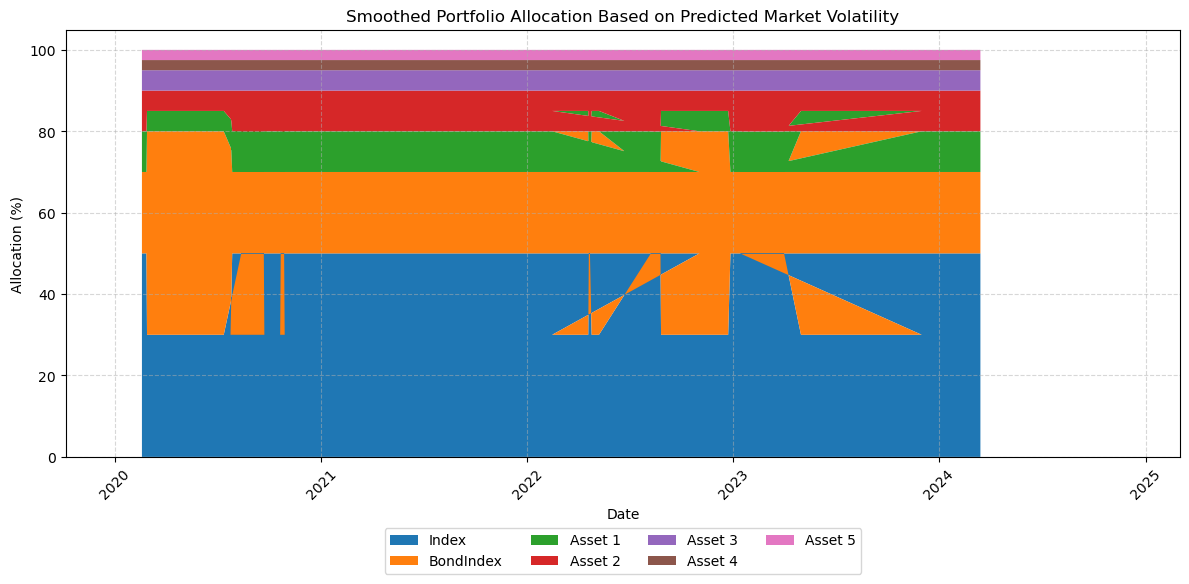

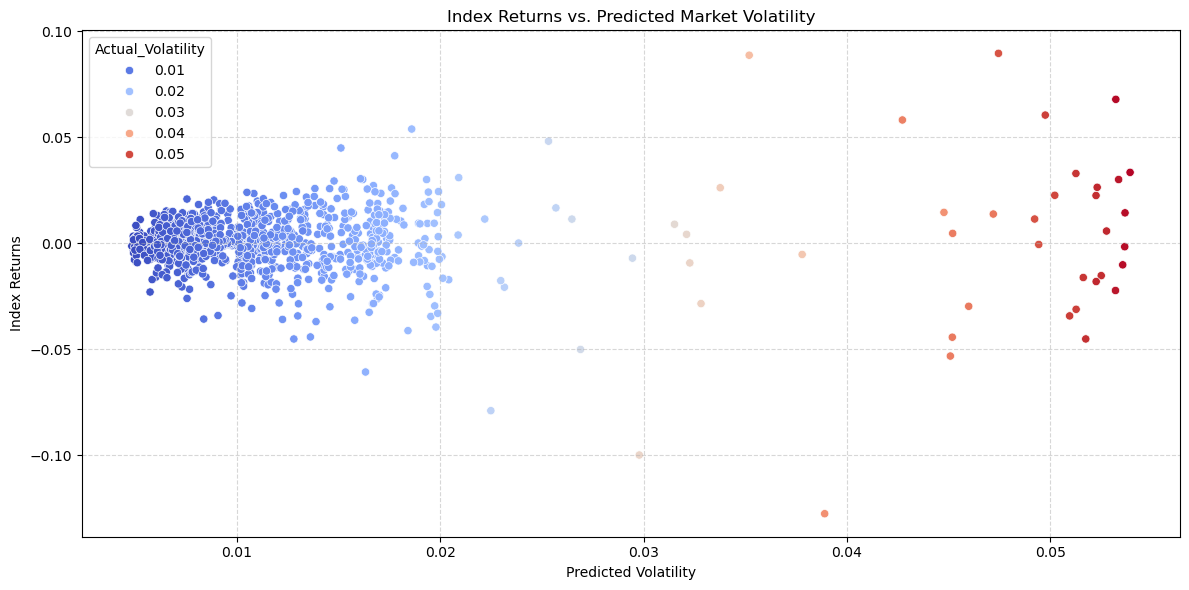

✅ Analysis complete. PNG and CSV files saved.

📊 BACKTEST RESULTS COMPARISON
--------------------------------------------------
Metric                    | Dynamic     | Base
Cumulative Return         | 41.38%    | 40.45%
Annualized Volatility     | 15.57%    | 20.19%
Sharpe Ratio (R_f=0)      | 0.04       | 0.03

📅 PREDICTED VOLATILITY AND ALLOCATIONS FOR NEXT 5 DAYS
--------------------------------------------------------
            Predicted_Volatility  Index  BondIndex  Asset 1  Asset 2  Asset 3  \
Date                                                                            
2024-03-15              0.007408     50         20       10       10        5   
2024-03-16              0.007408     50         20       10       10        5   
2024-03-17              0.007408     50         20       10       10        5   
2024-03-18              0.007408     50         20       10       10        5   
2024-03-19              0.007408     50         20       10       10        5   

    

In [10]:
# Area Chart - Dynamic Portfolio Allocations
plt.figure(figsize=(12, 6))
plt.stackplot(final_data["Date"], [final_data[asset] for asset in asset_columns], labels=asset_columns)
plt.title("Smoothed Portfolio Allocation Based on Predicted Market Volatility")
plt.xlabel("Date")
plt.ylabel("Allocation (%)")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(my_area_chart, dpi=300)
plt.show()

# Risk-Adjusted Returns - Scatter Plot
plt.figure(figsize=(12, 6))
plot_data = pd.DataFrame(index=returns.index)
plot_data["Returns"] = returns[primary_asset]
plot_data["Predicted_Volatility"] = returns["Predicted_Volatility"]
plot_data["Actual_Volatility"] = returns["Volatility"]
plot_data.dropna(inplace=True)

sns.scatterplot(
    x="Predicted_Volatility",
    y="Returns",
    hue="Actual_Volatility",
    data=plot_data,
    palette="coolwarm"
)
plt.title(f"{primary_asset} Returns vs. Predicted Market Volatility")
plt.xlabel("Predicted Volatility")
plt.ylabel(f"{primary_asset} Returns")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(my_returns, dpi=300)
plt.show()

print("✅ Analysis complete. PNG and CSV files saved.")

# Results of forecast and backtest results

# Print backtest results
print("\n📊 BACKTEST RESULTS COMPARISON")
print("--------------------------------------------------")
print("Metric                    | Dynamic     | Base")
print(f"Cumulative Return         | {dyn_ret:.2%}    | {stat_ret:.2%}")
print(f"Annualized Volatility     | {dyn_vol * np.sqrt(252):.2%}    | {stat_vol * np.sqrt(252):.2%}")
print(f"Sharpe Ratio (R_f=0)      | {dyn_sharpe:.2f}       | {stat_sharpe:.2f}")

# Create DataFrame to hold predictions and allocations

latest_date = returns.index[-1]
future_dates = [latest_date + timedelta(days=i+1) for i in range(5)]
future_df = pd.DataFrame(future_allocations, index=future_dates)
future_df.index.name = "Date"
future_df.insert(0, "Predicted_Volatility", future_pred_vols)

# Display future allocations
print("\n📅 PREDICTED VOLATILITY AND ALLOCATIONS FOR NEXT 5 DAYS")
print("--------------------------------------------------------")
print(future_df)

# Save to CSV
future_df.reset_index().to_csv("0712 Future allocation.csv", index=False)
print("\n✅ Future allocations saved to '0712 Future allocation.csv'")
